In [1]:
# including the project directory to the notebook level
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    import tensorflow as tf
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


# Modeling Chilled Water Energy

In [3]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothed_buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [4]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.085561,73.399236,84.996351,12.247199,0.061145,523.448686,72.438053,0.004498,6.769096,107.185437,98.426348
2018-11-16 10:10:00,31.084241,73.174948,85.162961,12.049303,1.239401,530.628172,72.436722,0.004635,7.174604,108.380930,97.960950
2018-11-16 10:15:00,31.082809,72.953222,85.338500,11.855933,2.364778,537.912446,72.435385,0.004748,7.570829,109.490329,97.490620
2018-11-16 10:20:00,31.081329,72.737975,85.531478,11.673648,3.409979,545.266988,72.434065,0.004843,7.942075,110.468679,97.028119
2018-11-16 10:25:00,31.079893,72.531779,85.748990,11.508193,4.338237,552.652147,72.432798,0.004924,8.275292,111.291654,96.587022


In [27]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(
    df[['oat', 'orh', 'sat', 'ghi', 'flow', 'cwe']],
    subsequence=True,
    period=1,
    days=7,
    hours=0)

In [28]:
len(dflist)

7

In [29]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat','orh', 'sat', 'ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=0.75
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

#### A different way to merge data

In [ ]:
from pandas import concat
def quickmerge(df1,df2):
    return concat([df1,df2])

# create list of training, testing arrays
weeklist = []
for weekid in range(len(dflist)-1):  # [:40]:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        quickmerge(dflist[weekid],dflist[weekid+1]),
        predictorcols=['oat','orh', 'sat', 'ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

print('Length of weeklist: {}'.format(len(weeklist)))

In [30]:
for week in weeklist:
    for key,value in week.items():
        print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)
name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)
name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)
name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)
name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)
name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)
name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)


In [31]:
path = '../results/lstm_cwe_2/'
!rm -rf ../results/lstm_cwe_2

In [32]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [33]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [34]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4, #4
    'lstm_no_layers': 1, #1
    'dense_hidden_units':8, #1
    'dense_no_layers': 1, #8
    'train_epochs':5000
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        model = mp.lstm_model(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        # modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=config['train_epochs'],
                                initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno+1)

  0%|          | 0/7 [00:00<?, ?it/s]

Train on 1511 samples, validate on 504 samples
Epoch 1/5000
 - 1s - loss: 0.3553 - val_loss: 0.1697
Epoch 2/5000
 - 0s - loss: 0.1827 - val_loss: 0.0755
Epoch 3/5000
 - 0s - loss: 0.1104 - val_loss: 0.0444
Epoch 4/5000
 - 0s - loss: 0.0753 - val_loss: 0.0364
Epoch 5/5000
 - 0s - loss: 0.0607 - val_loss: 0.0353
Epoch 6/5000
 - 0s - loss: 0.0548 - val_loss: 0.0351
Epoch 7/5000
 - 0s - loss: 0.0517 - val_loss: 0.0347
Epoch 8/5000
 - 0s - loss: 0.0495 - val_loss: 0.0340
Epoch 9/5000
 - 0s - loss: 0.0477 - val_loss: 0.0331
Epoch 10/5000
 - 0s - loss: 0.0460 - val_loss: 0.0320
Epoch 11/5000
 - 0s - loss: 0.0442 - val_loss: 0.0308
Epoch 12/5000
 - 0s - loss: 0.0425 - val_loss: 0.0296
Epoch 13/5000
 - 0s - loss: 0.0408 - val_loss: 0.0285
Epoch 14/5000
 - 0s - loss: 0.0392 - val_loss: 0.0274
Epoch 15/5000
 - 0s - loss: 0.0377 - val_loss: 0.0263
Epoch 16/5000
 - 0s - loss: 0.0364 - val_loss: 0.0255
Epoch 17/5000
 - 0s - loss: 0.0353 - val_loss: 0.0248
Epoch 18/5000
 - 0s - loss: 0.0344 - val_los

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
 14%|█▍        | 1/7 [00:27<02:42, 27.17s/it]

Train on 1511 samples, validate on 504 samples
Epoch 63/5000
 - 1s - loss: 0.0729 - val_loss: 0.0449
Epoch 64/5000
 - 0s - loss: 0.0418 - val_loss: 0.0305
Epoch 65/5000
 - 0s - loss: 0.0395 - val_loss: 0.0289
Epoch 66/5000
 - 0s - loss: 0.0385 - val_loss: 0.0280
Epoch 67/5000
 - 0s - loss: 0.0378 - val_loss: 0.0273
Epoch 68/5000
 - 0s - loss: 0.0371 - val_loss: 0.0267
Epoch 69/5000
 - 0s - loss: 0.0364 - val_loss: 0.0261
Epoch 70/5000
 - 0s - loss: 0.0357 - val_loss: 0.0254
Epoch 71/5000
 - 0s - loss: 0.0349 - val_loss: 0.0247
Epoch 72/5000
 - 0s - loss: 0.0341 - val_loss: 0.0237
Epoch 73/5000
 - 0s - loss: 0.0331 - val_loss: 0.0227
Epoch 74/5000
 - 0s - loss: 0.0317 - val_loss: 0.0216
Epoch 75/5000
 - 0s - loss: 0.0303 - val_loss: 0.0208
Epoch 76/5000
 - 0s - loss: 0.0290 - val_loss: 0.0202
Epoch 77/5000
 - 0s - loss: 0.0281 - val_loss: 0.0198
Epoch 78/5000
 - 0s - loss: 0.0274 - val_loss: 0.0195
Epoch 79/5000
 - 0s - loss: 0.0269 - val_loss: 0.0192
Epoch 80/5000
 - 0s - loss: 0.0264 

 29%|██▊       | 2/7 [00:55<02:17, 27.52s/it]

Train on 1511 samples, validate on 504 samples
Epoch 128/5000
 - 1s - loss: 0.0872 - val_loss: 0.0776
Epoch 129/5000
 - 0s - loss: 0.0416 - val_loss: 0.0449
Epoch 130/5000
 - 0s - loss: 0.0325 - val_loss: 0.0355
Epoch 131/5000
 - 0s - loss: 0.0287 - val_loss: 0.0305
Epoch 132/5000
 - 0s - loss: 0.0267 - val_loss: 0.0278
Epoch 133/5000
 - 0s - loss: 0.0258 - val_loss: 0.0263
Epoch 134/5000
 - 0s - loss: 0.0252 - val_loss: 0.0255
Epoch 135/5000
 - 0s - loss: 0.0247 - val_loss: 0.0249
Epoch 136/5000
 - 0s - loss: 0.0243 - val_loss: 0.0244
Epoch 137/5000
 - 0s - loss: 0.0240 - val_loss: 0.0240
Epoch 138/5000
 - 0s - loss: 0.0236 - val_loss: 0.0236
Epoch 139/5000
 - 0s - loss: 0.0232 - val_loss: 0.0232
Epoch 140/5000
 - 0s - loss: 0.0229 - val_loss: 0.0228
Epoch 141/5000
 - 0s - loss: 0.0225 - val_loss: 0.0224
Epoch 142/5000
 - 0s - loss: 0.0222 - val_loss: 0.0221
Epoch 143/5000
 - 0s - loss: 0.0218 - val_loss: 0.0217
Epoch 144/5000
 - 0s - loss: 0.0215 - val_loss: 0.0213
Epoch 145/5000
 - 

 43%|████▎     | 3/7 [01:20<01:47, 26.77s/it]

Train on 1511 samples, validate on 504 samples
Epoch 184/5000
 - 1s - loss: 0.2268 - val_loss: 0.0785
Epoch 185/5000
 - 0s - loss: 0.0972 - val_loss: 0.0430
Epoch 186/5000
 - 0s - loss: 0.0539 - val_loss: 0.0419
Epoch 187/5000
 - 0s - loss: 0.0417 - val_loss: 0.0440
Epoch 188/5000
 - 0s - loss: 0.0375 - val_loss: 0.0434
Epoch 189/5000
 - 0s - loss: 0.0352 - val_loss: 0.0433
Epoch 190/5000
 - 0s - loss: 0.0350 - val_loss: 0.0432
Epoch 191/5000
 - 0s - loss: 0.0347 - val_loss: 0.0431
Epoch 192/5000
 - 0s - loss: 0.0344 - val_loss: 0.0430
Epoch 193/5000
 - 0s - loss: 0.0341 - val_loss: 0.0429
Epoch 194/5000
 - 0s - loss: 0.0341 - val_loss: 0.0429


 57%|█████▋    | 4/7 [01:29<01:03, 21.33s/it]

Train on 1511 samples, validate on 504 samples
Epoch 195/5000
 - 1s - loss: 0.4638 - val_loss: 0.3423
Epoch 196/5000
 - 0s - loss: 0.1669 - val_loss: 0.0871
Epoch 197/5000
 - 0s - loss: 0.0305 - val_loss: 0.0147
Epoch 198/5000
 - 0s - loss: 0.0170 - val_loss: 0.0091
Epoch 199/5000
 - 0s - loss: 0.0165 - val_loss: 0.0072
Epoch 200/5000
 - 0s - loss: 0.0159 - val_loss: 0.0064
Epoch 201/5000
 - 0s - loss: 0.0158 - val_loss: 0.0060
Epoch 202/5000
 - 0s - loss: 0.0157 - val_loss: 0.0058
Epoch 203/5000
 - 0s - loss: 0.0157 - val_loss: 0.0056
Epoch 204/5000
 - 0s - loss: 0.0156 - val_loss: 0.0055
Epoch 205/5000
 - 0s - loss: 0.0156 - val_loss: 0.0054
Epoch 206/5000
 - 0s - loss: 0.0155 - val_loss: 0.0053
Epoch 207/5000
 - 0s - loss: 0.0154 - val_loss: 0.0052
Epoch 208/5000
 - 0s - loss: 0.0154 - val_loss: 0.0051
Epoch 209/5000
 - 0s - loss: 0.0153 - val_loss: 0.0050
Epoch 210/5000
 - 0s - loss: 0.0152 - val_loss: 0.0050
Epoch 211/5000
 - 0s - loss: 0.0151 - val_loss: 0.0049
Epoch 212/5000
 - 

 71%|███████▏  | 5/7 [01:45<00:39, 19.76s/it]

Train on 1511 samples, validate on 504 samples
Epoch 227/5000
 - 1s - loss: 0.2220 - val_loss: 0.1634
Epoch 228/5000
 - 0s - loss: 0.1489 - val_loss: 0.1083
Epoch 229/5000
 - 0s - loss: 0.1120 - val_loss: 0.0706
Epoch 230/5000
 - 0s - loss: 0.0822 - val_loss: 0.0383
Epoch 231/5000
 - 0s - loss: 0.0575 - val_loss: 0.0183
Epoch 232/5000
 - 0s - loss: 0.0446 - val_loss: 0.0121
Epoch 233/5000
 - 0s - loss: 0.0403 - val_loss: 0.0110
Epoch 234/5000
 - 0s - loss: 0.0386 - val_loss: 0.0105
Epoch 235/5000
 - 0s - loss: 0.0371 - val_loss: 0.0100
Epoch 236/5000
 - 0s - loss: 0.0355 - val_loss: 0.0094
Epoch 237/5000
 - 0s - loss: 0.0339 - val_loss: 0.0088
Epoch 238/5000
 - 0s - loss: 0.0323 - val_loss: 0.0083
Epoch 239/5000
 - 0s - loss: 0.0307 - val_loss: 0.0079
Epoch 240/5000
 - 0s - loss: 0.0291 - val_loss: 0.0076
Epoch 241/5000
 - 0s - loss: 0.0274 - val_loss: 0.0075
Epoch 242/5000
 - 0s - loss: 0.0258 - val_loss: 0.0075
Epoch 243/5000
 - 0s - loss: 0.0247 - val_loss: 0.0077
Epoch 244/5000
 - 

 86%|████████▌ | 6/7 [01:58<00:17, 17.82s/it]

Train on 1511 samples, validate on 504 samples
Epoch 250/5000
 - 1s - loss: 0.0589 - val_loss: 0.0349
Epoch 251/5000
 - 0s - loss: 0.0357 - val_loss: 0.0255
Epoch 252/5000
 - 0s - loss: 0.0333 - val_loss: 0.0243
Epoch 253/5000
 - 0s - loss: 0.0328 - val_loss: 0.0240
Epoch 254/5000
 - 0s - loss: 0.0325 - val_loss: 0.0237
Epoch 255/5000
 - 0s - loss: 0.0322 - val_loss: 0.0234
Epoch 256/5000
 - 0s - loss: 0.0319 - val_loss: 0.0232
Epoch 257/5000
 - 0s - loss: 0.0315 - val_loss: 0.0229
Epoch 258/5000
 - 0s - loss: 0.0311 - val_loss: 0.0226
Epoch 259/5000
 - 0s - loss: 0.0307 - val_loss: 0.0223
Epoch 260/5000
 - 0s - loss: 0.0303 - val_loss: 0.0220
Epoch 261/5000
 - 0s - loss: 0.0299 - val_loss: 0.0217
Epoch 262/5000
 - 0s - loss: 0.0294 - val_loss: 0.0214
Epoch 263/5000
 - 0s - loss: 0.0289 - val_loss: 0.0211
Epoch 264/5000
 - 0s - loss: 0.0285 - val_loss: 0.0207
Epoch 265/5000
 - 0s - loss: 0.0280 - val_loss: 0.0205
Epoch 266/5000
 - 0s - loss: 0.0276 - val_loss: 0.0202
Epoch 267/5000
 - 

100%|██████████| 7/7 [02:15<00:00, 19.38s/it]


Name of the file:  ../results/lstm_cwe_2/5min Results_File.txt


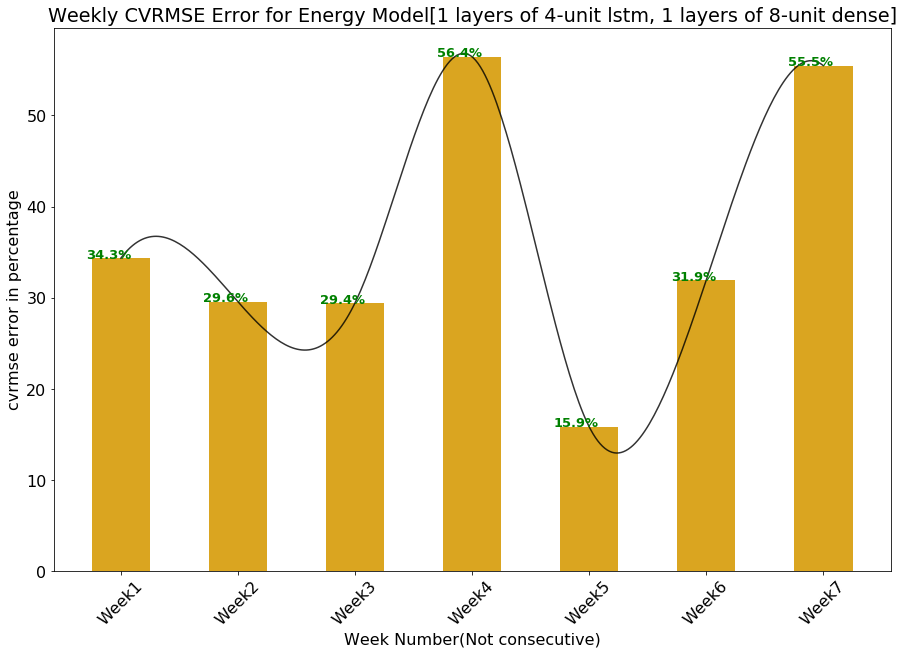

In [35]:
# Open a file
fo = open(path+"5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = path,
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly CVRMSE Error for Energy Model[{} layers of {}-unit lstm, {} layers of {}-unit dense]'.format(config['lstm_no_layers'],config['lstm_hidden_units'], config['dense_no_layers'],config['dense_hidden_units']),
    xticktype = 'Week'
)
pu.single_bar_plot(
    **plot_args
)

In [ ]:
model.show_model()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '../results/lstmtrain/loginfo/' --port 8200

In [ ]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)

# Modeling Hot Water Energy

In [36]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothed_buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [37]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.085561,73.399236,84.996351,12.247199,0.061145,523.448686,72.438053,0.004498,6.769096,107.185437,98.426348
2018-11-16 10:10:00,31.084241,73.174948,85.162961,12.049303,1.239401,530.628172,72.436722,0.004635,7.174604,108.380930,97.960950
2018-11-16 10:15:00,31.082809,72.953222,85.338500,11.855933,2.364778,537.912446,72.435385,0.004748,7.570829,109.490329,97.490620
2018-11-16 10:20:00,31.081329,72.737975,85.531478,11.673648,3.409979,545.266988,72.434065,0.004843,7.942075,110.468679,97.028119
2018-11-16 10:25:00,31.079893,72.531779,85.748990,11.508193,4.338237,552.652147,72.432798,0.004924,8.275292,111.291654,96.587022


In [38]:
df.tail()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2020-02-12 06:30:00,59.062424,73.257595,58.469692,-0.340155,2.867506,-0.000006,72.647619,0.000745,21.591509,117.618939,108.524975
2020-02-12 06:40:00,60.396597,73.057491,58.371276,-0.321477,2.205102,-0.000008,72.647619,0.000752,23.946071,118.739598,109.623482
2020-02-12 06:50:00,61.679009,72.877133,58.280555,-0.292277,1.521950,-0.000009,72.647619,0.000758,26.056081,119.688174,110.793781
2020-02-12 06:55:00,62.892696,72.716843,58.198122,-0.257719,0.838166,-0.000009,72.647619,0.000765,27.914109,120.468804,111.982709
2020-02-12 07:00:00,64.022514,72.575756,58.124085,-0.221789,0.181070,-0.000009,72.647619,0.000771,29.531381,121.112145,113.159061


In [39]:
df.shape[0]/2016

51.910714285714285

In [75]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df[['oat', 'orh', 'sat', 'ghi', 'hw_sf', 'hwe', 'hw_st']],
                      subsequence=True,
                      period=1,
                      days=21,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 1


In [76]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:  # [:40]:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st'],
        outputcols=['hwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=0.85
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 1


### We will merge two successive week data together

In [49]:
from pandas import concat
def quickmerge(df1,df2):
    return concat([df1,df2])

# create list of training, testing arrays
weeklist = []
for weekid in range(len(dflist)-1):  # [:40]:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        quickmerge(dflist[weekid],dflist[weekid+1]),
        predictorcols=['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st'],
        outputcols=['hwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=0.75
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 6


In [77]:
for week in weeklist:
    for key,value in week.items():
        print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (5139, 1, 6)
name: y_train, value: (5139, 1, 1)
name: X_test, value: (908, 1, 6)
name: y_test, value: (908, 1, 1)


### Run from here to rerun training with same data

In [78]:
path = '../results/lstm_hwe_4/'
!rm -rf ../results/lstm_hwe_4

In [79]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [80]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [81]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4,
    'lstm_no_layers': 1,
    'dense_hidden_units':8,
    'dense_no_layers': 2,
    'train_epochs':3000
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        model = mp.lstm_model(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        # modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=config['train_epochs'],
                                initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno+1)

  0%|          | 0/1 [00:00<?, ?it/s]

Train on 5139 samples, validate on 908 samples
Epoch 1/3000
 - 1s - loss: 0.1526 - val_loss: 0.0331
Epoch 2/3000
 - 1s - loss: 0.0360 - val_loss: 0.0366
Epoch 3/3000
 - 1s - loss: 0.0302 - val_loss: 0.0360
Epoch 4/3000
 - 1s - loss: 0.0321 - val_loss: 0.0323
Epoch 5/3000
 - 1s - loss: 0.0294 - val_loss: 0.0302
Epoch 6/3000
 - 1s - loss: 0.0282 - val_loss: 0.0288
Epoch 7/3000
 - 1s - loss: 0.0275 - val_loss: 0.0280
Epoch 8/3000
 - 1s - loss: 0.0270 - val_loss: 0.0274
Epoch 9/3000
 - 1s - loss: 0.0265 - val_loss: 0.0270
Epoch 10/3000
 - 1s - loss: 0.0261 - val_loss: 0.0266
Epoch 11/3000
 - 1s - loss: 0.0257 - val_loss: 0.0262
Epoch 12/3000
 - 1s - loss: 0.0253 - val_loss: 0.0257
Epoch 13/3000
 - 1s - loss: 0.0248 - val_loss: 0.0254
Epoch 14/3000
 - 1s - loss: 0.0244 - val_loss: 0.0250
Epoch 15/3000
 - 1s - loss: 0.0240 - val_loss: 0.0247
Epoch 16/3000
 - 1s - loss: 0.0235 - val_loss: 0.0244
Epoch 17/3000
 - 1s - loss: 0.0231 - val_loss: 0.0241
Epoch 18/3000
 - 1s - loss: 0.0227 - val_los

100%|██████████| 1/1 [01:04<00:00, 64.88s/it]


Name of the file:  ../results/lstm_hwe_4/5min Results_File.txt


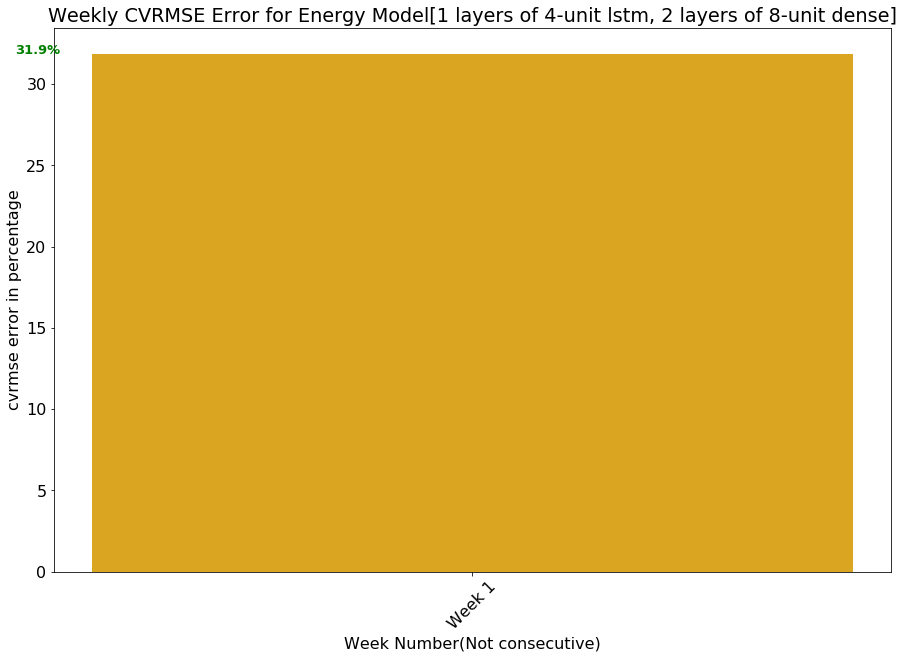

In [83]:
# Open a file
fo = open(path+"5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = path,
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly CVRMSE Error for Energy Model[{} layers of {}-unit lstm, {} layers of {}-unit dense]'.format(config['lstm_no_layers'],config['lstm_hidden_units'], config['dense_no_layers'],config['dense_hidden_units']),
    xticktype = 'Week '
)
pu.single_bar_plot(
    **plot_args
)